In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax
import numpy.random as npr
import jax

import itertools
from functools import partial
# np = jax.numpy
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [313]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
        
    @staticmethod
    @partial(jit, static_argnums=(1,2, 5))
    def loss_for_trajectory(Xt, b_f, b_b, dt, theta, forwards):
        
        if not forwards : Xt = Xt[::-1, :]
        
        b_minus  = b_b(theta, Xt)
        b_plus = b_f(theta, Xt)
        
        delta_Xt = Xt[:-1, :]  - Xt[1:, :]
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[1:,:] - b_minus[:-1,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * dt # Not sure about this dt here
        
        return ito_integral.sum() - 0.5 * time_integral.sum()
        
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    @staticmethod
    def sample_trajectory(X, dt, theta, sigma, b, N, sde_solver, forwards=True):
        return sde_solver(alfa=b, beta=sigma,
                          dt=dt, X0=X,
                          N=N, theta=theta)

    @staticmethod
#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(terminal_index, theta, batch, dt, 
                       batch_terminal_empirical, H , b_forward,
                       b_backward, sigma, N, sde_solver, forwards):
        
        b = (b_forward if forwards else (lambda X, theta: -b_backward(X, theta)))
        
        def inner_loss_loop(x):
            t, Xt = cIPFP.sample_trajectory(x, dt, theta,  sigma, b, N, sde_solver, forwards)
            cross_entropy = -log_kde_pdf_per_point(Xt[-1].reshape(-1,1), batch_terminal_empirical, H)
            main_term = cIPFP.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)
            return main_term + cross_entropy 
            
#         for x in batch:
#             t, Xt = cIPFP.sample_trajectory(x, dt, theta,  sigma, b, N, sde_solver, forwards)
            
#             cross_entropy = log_kde_pdf_per_point(Xt[terminal_index].reshape(-1,1), batch_terminal_empirical, H)
            
#             J += cIPFP.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)
            
#             J += cross_entropy
        
#         J /= len(batch)
        J = np.mean(jax.vmap(inner_loss_loop)(batch))
        J = np.squeeze(J)
#         J = J.block_until_ready() 
        return J
    
    @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)
        dt = self.dt
        N = self.number_time_steps
        sde_solver = self.sde_solver
        sigma = self.sigma

        def inner_loss_loop(x):
            t, Xt = cIPFP.sample_trajectory(x, dt, theta,  sigma, b, N, sde_solver, forwards)
            return Xt[-1, :]

        batch_y = jax.vmap(inner_loss_loop)(batch_x)
        return batch_y
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        terminal_index = -1 if forwards else 0
        X_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            terminal_index, theta, batch, self.dt, 
            X_terminal_empirical, H , self.b_forward,
            self.b_backward, self.sigma, self.number_time_steps, self.sde_solver, forwards
        )

    @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        for i in range(IPFP_iterations):
                                               
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
#                     print(_)
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)
                                               
            
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
#                     print(_)
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), True
                    )
                params = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)
         

        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
            

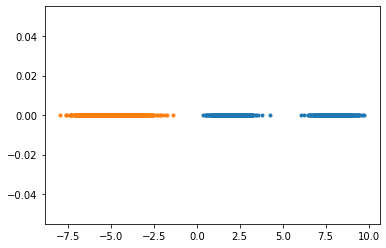

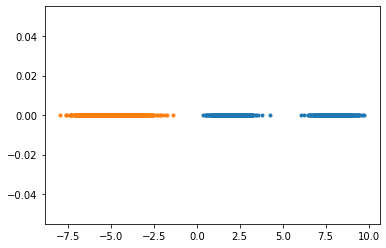

In [314]:
n = 1000
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 5
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 8
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) + 2
X2 = np.concatenate((X21, X22), axis=0)

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [315]:
c = cIPFP(X1, X2,  number_time_steps=100, batch_size=100 , step_size = 0.0001, weights=[500,])

In [316]:
 _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
opt_state_f = c.opt_init_f(init_params_f)


theta_f = c.get_params_f(opt_state_f)

In [317]:
theta_f[0][1].shape, theta_f[1]

((500,), ())

((500,), ())

In [318]:
t, Xt = c.sample_trajectory(X1[0],c.dt,  theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, True)

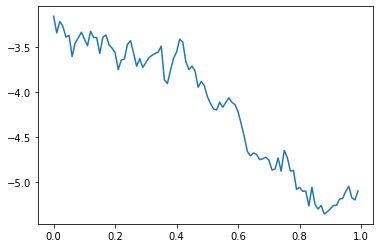

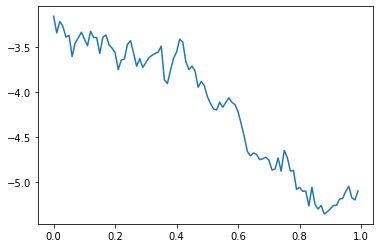

In [319]:
import matplotlib.pyplot as plt

plt.plot(t, Xt.flatten())

In [289]:
import numpy as onp
import jax.numpy as np

X0 = np.array(X1[0,:])
t0=0

alfa  = c.b_forward 
beta = c.sigma
randn = onp.random.randn
dt = c.dt
N= c.number_time_steps
theta = theta_f


if alfa is None or beta is None:
    raise ValueError("Error: SDE not defined.")


X0 = randn(*alfa(0, 0).shape) if X0 is None else np.array(X0)
#     DW = (lambda Y, dt: randn((len(X0))) * np.sqrt(dt)) if DW is None else DW
DWs  = randn(N-1, len(X0))  * np.sqrt(dt)



Y, ti = np.zeros((N, len(X0))), np.arange(N)*dt + t0
Y = jax.ops.index_update(Y, jax.ops.index[0,:],  X0)



In [290]:
loss= c.loss_for_trajectory(Xt, c.b_forward, c.b_backward, c.dt, theta_f, True)

In [291]:
cross_entropy = log_kde_pdf_per_point(Xt[-1].reshape(-1,1), X2, c.H_0)

In [292]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 635 ms, sys: 3.98 ms, total: 639 ms
Wall time: 601 ms
CPU times: user 635 ms, sys: 3.98 ms, total: 639 ms
Wall time: 601 ms


DeviceArray(70.717125, dtype=float32)

DeviceArray(70.717125, dtype=float32)

In [293]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 8.94 ms, sys: 4.05 ms, total: 13 ms
Wall time: 7.6 ms


DeviceArray(36.620647, dtype=float32)

CPU times: user 8.94 ms, sys: 4.05 ms, total: 13 ms
Wall time: 7.6 ms


DeviceArray(36.620647, dtype=float32)

In [294]:

# _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
# opt_state_f = c.opt_init_f(init_params_f)

# _, init_params_b = c.b_backward_init(c.rng, (-1, c.dim))                                               
# opt_state_b = c.opt_init_b(init_params_b)

# batches_f = c.data_stream(forward=True)
# batches_b = c.data_stream(forward=False)

# c.update(0, opt_state_b, next(batches_b), forwards=False)
                                       

In [295]:
from jax import grad


In [296]:
%%time
gradient = jit(grad(c.inner_loss), static_argnums=(2))
kek = gradient(theta_f, X1, True)
# partial(jit, static_argnums=(2))(gradient)

CPU times: user 2.73 s, sys: 15.6 ms, total: 2.74 s
Wall time: 2.73 s
CPU times: user 2.73 s, sys: 15.6 ms, total: 2.74 s
Wall time: 2.73 s


In [297]:
%%time
kek = gradient(theta_f, X1, True)

CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 757 µs
CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 757 µs


loss b 170.72885131835938
loss b 170.72885131835938
loss f 30.20648765563965
loss f 30.20648765563965


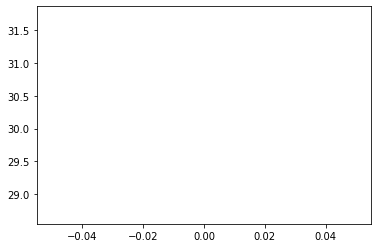

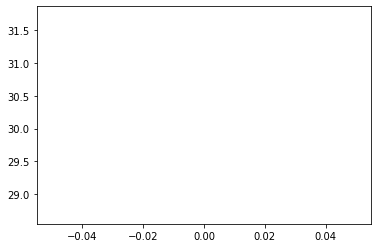

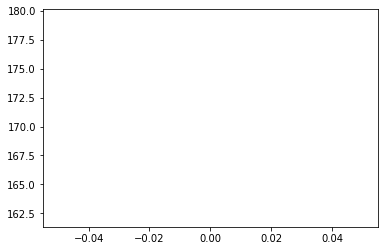

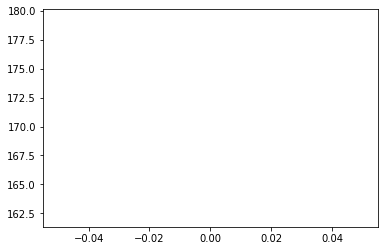

CPU times: user 1min 10s, sys: 1.26 s, total: 1min 11s
Wall time: 1min 8s
CPU times: user 1min 10s, sys: 1.26 s, total: 1min 11s
Wall time: 1min 8s


In [320]:
%%time
c.fit(1,1)

loss b 379.93316650390625
loss b 379.93316650390625
loss f 26.652599334716797
loss f 26.652599334716797


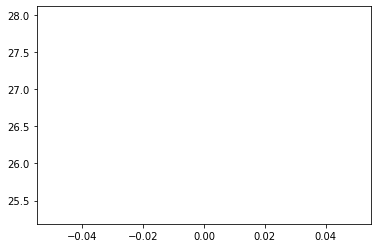

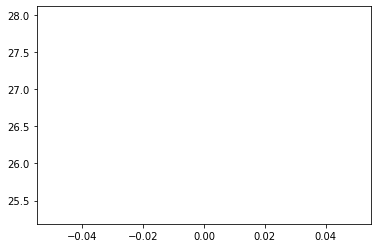

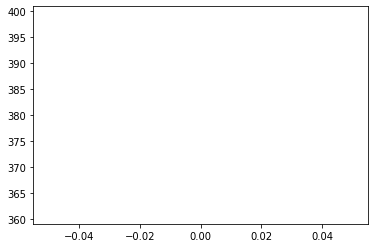

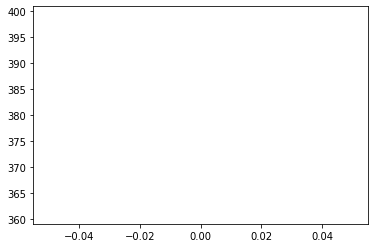

CPU times: user 2.71 s, sys: 1.25 s, total: 3.96 s
Wall time: 1.93 s
CPU times: user 2.71 s, sys: 1.25 s, total: 3.96 s
Wall time: 1.93 s


In [321]:
%%time
c.fit(1,1)

In [ ]:
c.fit(100,30)

loss b 300.6606140136719
loss b 300.6606140136719
loss b 225.8924560546875
loss b 225.8924560546875
loss b 284.1995849609375
loss b 284.1995849609375
loss b 169.59661865234375
loss b 193.16766357421875
loss b 202.37965393066406
loss b 140.0609893798828
loss b 212.1272430419922
loss b 205.59849548339844
loss b 210.63882446289062
loss b 128.99307250976562
loss b 166.05609130859375
loss b 64.36531066894531
loss b 93.09819030761719
loss b 100.2965316772461
loss b 110.13459777832031
loss b 165.79351806640625
loss b 142.8853302001953
loss b 118.91444396972656
loss b 109.36688232421875
loss b 177.96527099609375
loss b 56.375030517578125
loss b 77.4922866821289
loss b 88.93338012695312
loss b 84.94534301757812
loss b 120.61088562011719
loss b 72.31107330322266
loss b 104.63082885742188
loss b 85.68199920654297
loss b 76.16159057617188
loss f 39.406742095947266
loss f 56.304935455322266
loss f 41.76677322387695
loss f 63.157901763916016
loss f 71.35428619384766
loss f 42.647674560546875
loss f 

loss b 28.14200210571289
loss b 13.247754096984863
loss b 35.22816467285156
loss b 16.652067184448242
loss b 35.71186828613281
loss b 12.112975120544434
loss b 15.103155136108398
loss b 15.174823760986328
loss b 24.032272338867188
loss b 8.73925495147705
loss b 11.723937034606934
loss f 5.719141960144043
loss f 5.909771919250488
loss f 2.5945980548858643
loss f 4.575282573699951
loss f 4.273963451385498
loss f 3.136242389678955
loss f 6.710806846618652
loss f 6.590458869934082
loss f 3.2560956478118896
loss f 4.191293239593506
loss f 6.188913345336914
loss f 2.1309661865234375
loss f 5.021724700927734
loss f 3.697324752807617
loss f 8.041680335998535
loss f 2.179377794265747
loss f 1.944085955619812
loss f 3.9675121307373047
loss f 1.766417384147644
loss f 3.7434558868408203
loss f 2.98283052444458
loss f 7.872231483459473
loss f 3.2358973026275635
loss f 4.468141555786133
loss f 6.4352192878723145
loss f 3.3736572265625
loss f 3.993307590484619
loss f 3.686213731765747
loss f 2.074129

loss f 2.209336757659912
loss f 2.6323580741882324
loss f 2.8161096572875977
loss f 1.6044789552688599
loss f 2.534730911254883
loss f 5.908212661743164
loss f 3.5503780841827393
loss f 1.8254332542419434
loss f 1.8375931978225708
loss f 2.171740770339966
loss f 2.0083484649658203
loss f 2.3435347080230713
loss f 4.282675266265869
loss f 2.9612832069396973
loss f 2.082674264907837
loss f 2.1917364597320557
loss f 2.817563772201538
loss f 1.8974533081054688
loss b 3.3472118377685547
loss b 7.5408759117126465
loss b 5.518044471740723
loss b 10.585532188415527
loss b 4.452925682067871
loss b 3.874906301498413
loss b 9.255781173706055
loss b 4.53215217590332
loss b 3.8921399116516113
loss b 3.298116683959961
loss b 3.840724468231201
loss b 4.874467372894287
loss b 14.803071022033691
loss b 3.5756454467773438
loss b 5.2029571533203125
loss b 6.075962543487549
loss b 6.5420660972595215
loss b 6.597490310668945
loss b 10.551277160644531
loss b 4.054093837738037
loss b 9.305187225341797
loss b

loss b 5.2472310066223145
loss b 4.581516265869141
loss b 4.249068737030029
loss b 10.116320610046387
loss b 5.888891696929932
loss b 4.361405849456787
loss b 3.275251865386963
loss b 3.620210886001587
loss b 3.041710138320923
loss b 3.3412697315216064
loss b 4.1577043533325195
loss b 3.214061975479126
loss b 2.5223922729492188
loss b 4.308050632476807
loss b 3.3646128177642822
loss b 4.479857921600342
loss b 3.1693029403686523
loss b 13.404694557189941
loss b 3.605407953262329
loss b 8.725122451782227
loss b 3.78472900390625
loss b 2.721128463745117
loss b 3.677943229675293
loss b 4.8512349128723145
loss b 3.290433645248413
loss b 4.314216136932373
loss f 1.1346813440322876
loss f 0.49586501717567444
loss f 0.9187732934951782
loss f 0.5748350024223328
loss f 0.852522611618042
loss f 0.49739670753479004
loss f -1.4448972940444946
loss f 0.7446882128715515
loss f 0.8448707461357117
loss f 1.3655368089675903
loss f 0.5600436925888062
loss f 3.127908229827881
loss f 0.6244137287139893
los

loss b 2.946730852127075
loss b 4.473763465881348
loss b 15.775071144104004
loss b 6.6264238357543945
loss b 3.330362558364868
loss b 2.5535809993743896
loss b 3.330482244491577
loss f 1.2298765182495117
loss f 1.397890329360962
loss f 0.9883589148521423
loss f 0.9473125338554382
loss f 0.18918420374393463
loss f 2.6989078521728516
loss f 0.7424313426017761
loss f 0.42953670024871826
loss f 2.003981828689575
loss f 1.1022379398345947
loss f 1.3395624160766602
loss f 0.6979877352714539
loss f 0.3025147020816803
loss f 2.655843734741211
loss f 1.4050092697143555
loss f -0.6036353707313538
loss f 0.9436303973197937
loss f 0.45934367179870605
loss f 0.5322243571281433
loss f 1.306910753250122
loss f 3.2816948890686035
loss f -0.5510148406028748
loss f 2.8075978755950928
loss f 1.6755787134170532
loss f 2.6111068725585938
loss f 1.1599860191345215
loss f 0.7014002799987793
loss f 1.1900099515914917
loss f -0.18650883436203003
loss f 0.6535537242889404
loss b 2.8787407875061035
loss b 3.5072

loss f 0.7376797199249268
loss f 1.100934624671936
loss f 0.04978109523653984
loss f -0.1719546914100647
loss f 0.5275567173957825
loss f 0.4319254159927368
loss f 0.9704791903495789
loss f 0.6345594525337219
loss f 0.692111074924469
loss f 0.14293937385082245
loss f 0.400640070438385
loss f 0.5599371790885925
loss f 1.1376309394836426
loss f 0.9023618102073669
loss f 0.6955230832099915
loss f 0.4550739526748657
loss f 1.0147303342819214
loss f 0.6588143706321716
loss b 2.12343168258667
loss b 11.818275451660156
loss b 3.978595495223999
loss b 2.0789809226989746
loss b 4.68332052230835
loss b 4.7773308753967285
loss b 4.047606945037842
loss b 2.628115177154541
loss b 4.927494525909424
loss b 3.1490252017974854
loss b 5.9279279708862305
loss b 3.9279139041900635
loss b 3.4799957275390625
loss b 5.596581935882568
loss b 3.692737340927124
loss b 4.487835884094238
loss b 3.1505396366119385
loss b 3.4748611450195312
loss b 3.1424148082733154
loss b 5.289949417114258
loss b 13.95256710052490

In [254]:
t, Xt = c.sample_trajectory(X1[0],c.dt,  c.theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, True)

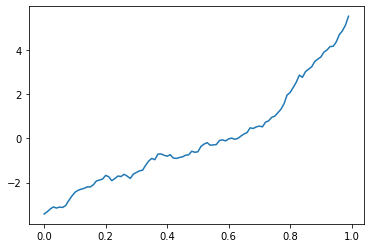

In [255]:
plt.plot(t.flatten(), Xt.flatten())

In [256]:
bb = lambda X, theta: -c.b_backward(X, theta)

t, Xt = c.sample_trajectory(X2[0],c.dt,  c.theta_b,  c.sigma, bb, c.number_time_steps, c.sde_solver, False)

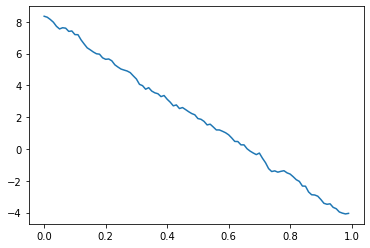

In [257]:
plt.plot(t.flatten(), Xt.flatten())

In [258]:
@partial(jit, static_argnums=(0,2))
def transport_batch(self, batch_x, forwards):
    theta = self.theta_f if forwards else self.theta_b
    b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)
    dt = self.dt
    N = self.number_time_steps
    sde_solver = self.sde_solver
    sigma = self.sigma

    def inner_loss_loop(x):
        t, Xt = cIPFP.sample_trajectory(x, dt, theta,  sigma, b, N, sde_solver, forwards)
        return Xt[-1, :]

    batch_y = jax.vmap(inner_loss_loop)(batch_x)
    return batch_y

In [261]:
X22 = transport_batch(c, X1, True)

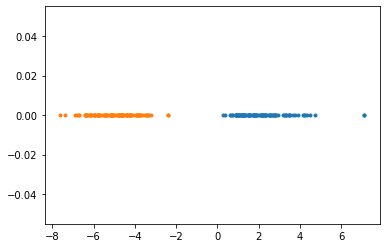

In [267]:
plt.plot(X1.flatten(), [0] * 100, 'b.', label="Source")
plt.plot(X22.flatten(), [0] * 100, 'r.', label="Transformed")
plt.plot(X2.flatten(), [0] * 100, 'g.', label="Target")
plt.legend()

In [221]:
X22.mean()

DeviceArray(4.0651765, dtype=float32)

In [222]:
X2.mean()

4.974274656883583

In [223]:
X1.mean()

-4.945354396506605

In [263]:
X11 = transport_batch(c, X2, False)

In [264]:
X11.mean()

DeviceArray(-5.043673, dtype=float32)

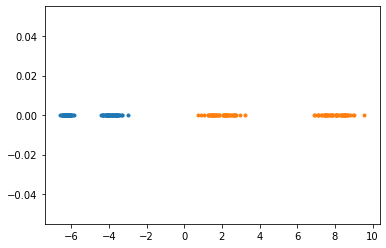

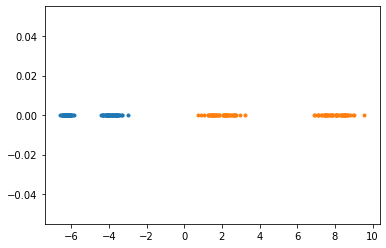

In [269]:
plt.plot(X2.flatten(), [0] * 100, 'b.', label="Source")
plt.plot(X11.flatten(), [0] * 100, 'r.', label="Transformed")
plt.plot(X1.flatten(), [0] * 100, 'g.', label="Target")
plt.legend()

In [ ]:
fig, axs = plt.subplots(12)

axs[0].plot(X2.flatten(), [0] * 100, 'b.', label="Source")
axs[0].plot(X11.flatten(), [0] * 100, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [0] * 100, 'g.', label="Target")
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * 100, 'b.', label="Source")
axs[1].plot(X22.flatten(), [0] * 100, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [0] * 100, 'g.', label="Target")
axs[0].legend()